### Imports and set up

In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.model_selection import train_test_split
from einops import rearrange

from torcheeg import transforms
from torcheeg.models.gnn.dgcnn import Chebynet
from torcheeg.models.gnn.dgcnn import GraphConvolution

from Training import TrainNN

import os
from cka import CKACalculator

## Path constants
data_path = "../../data/"
preprocessed_data_path = "preprocessed_data.npy"

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(path), io_mode='lmdb')

## Read metadata dataframeimports
metadata = pd.read_csv(path + 'sample_metadata.tsv', sep='\t')

### Load data

In [13]:
# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

In [16]:
if os.path.exists(preprocessed_data_path):
    
    with open(preprocessed_data_path, "rb") as f:
        X_bde = np.load(f)
    
else:
    t = transforms.BandDifferentialEntropy(band_dict={
                              "delta": [1, 4],
                              "theta": [4, 8],
                              "alpha": [8, 14],
                              "beta": [14, 31],
                              "gamma": [31, 49]
                          })

    X_bde = []
    for i in range(X.shape[0]):

        bde_tmp = t(eeg=X[i])
        X_bde.append(bde_tmp)

    X_bde = [x["eeg"] for x in X_bde]

    with open(preprocessed_data_path, "wb") as f:
        np.save(f, X_bde)

X_bde = torch.FloatTensor(X_bde)      

### Split data into train, validation and test sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_bde, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [18]:
# get dimensions

nsamples_train, nchannels_train, bands = X_train.shape
nsamples_val, nchannels_val, bands = X_val.shape

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

### Training & model hyperparameters

In [24]:
# Model parameters
n_chans = 5
n_electrodes = 22
n_outputs = y.max().item() + 1
n_layers = 2
hid_chans = 32

# Training parameters
lr = 1e-4
epochs = 40
w_decay = 0

#Models 
modruns = 4

## Train model

In [25]:
dgcnn_model = DGCNN(in_channels=n_chans, num_electrodes=n_electrodes, hid_channels=hid_chans, 
                    num_layers=n_layers, num_classes=n_outputs)

trainer = TrainNN()

dgcnn = trainer.train_model(dgcnn_model, train_loader, val_loader, learning_rate=lr, w_decay=w_decay,
                            epochs=epochs, prints=True, modrun=1)

Epoch 1/40, Train loss: 1.5263, Train acc: 29.45%| Val loss: 1.4061, Val acc: 33.65%
Epoch 2/40, Train loss: 1.3855, Train acc: 33.63%| Val loss: 1.3635, Val acc: 34.43%
Epoch 3/40, Train loss: 1.3481, Train acc: 35.53%| Val loss: 1.3443, Val acc: 36.35%
Epoch 4/40, Train loss: 1.3261, Train acc: 37.72%| Val loss: 1.3356, Val acc: 36.93%
Epoch 5/40, Train loss: 1.3096, Train acc: 39.26%| Val loss: 1.3266, Val acc: 37.80%
Epoch 6/40, Train loss: 1.3009, Train acc: 39.61%| Val loss: 1.3199, Val acc: 36.45%
Epoch 7/40, Train loss: 1.2898, Train acc: 40.23%| Val loss: 1.3105, Val acc: 37.90%
Epoch 8/40, Train loss: 1.2777, Train acc: 41.38%| Val loss: 1.3086, Val acc: 37.51%
Epoch 9/40, Train loss: 1.2724, Train acc: 41.41%| Val loss: 1.3032, Val acc: 37.99%
Epoch 10/40, Train loss: 1.2611, Train acc: 42.73%| Val loss: 1.2976, Val acc: 39.54%
Epoch 11/40, Train loss: 1.2562, Train acc: 42.70%| Val loss: 1.2994, Val acc: 40.02%
Epoch 12/40, Train loss: 1.2499, Train acc: 43.15%| Val loss: 1

### Train 4 models and calculate CKA matrices for pairs of models

In [27]:
mods = []

def train_models(model,modeltrain,num_models=1,new =False):
    
    for i in range(num_models):
        
        tmp_mod=model(in_channels=n_chans, num_electrodes=n_electrodes, hid_channels=hid_chans,
                      num_layers=n_layers, num_classes=n_outputs)
        pth=f"artifacts/eeg_nnmod{i}.pth"
        
        if new or not os.path.exists(pth):    
            if not os.path.exists(pth):
                print(f"Could not resolve path: {pth}")
            trainer = modeltrain()
            mods.append(trainer.train_model(tmp_mod, train_loader, val_loader, learning_rate=lr, 
                                            w_decay=w_decay,epochs=epochs, prints=False, modrun=i))
        else: 
            tmp_mod.load_state_dict(torch.load(f"artifacts/eeg_nnmod{i}.pth"))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])
            
train_models(DGCNN,TrainNN,num_models=modruns)

Processing CKA: 100%|█████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 332.79it/s]


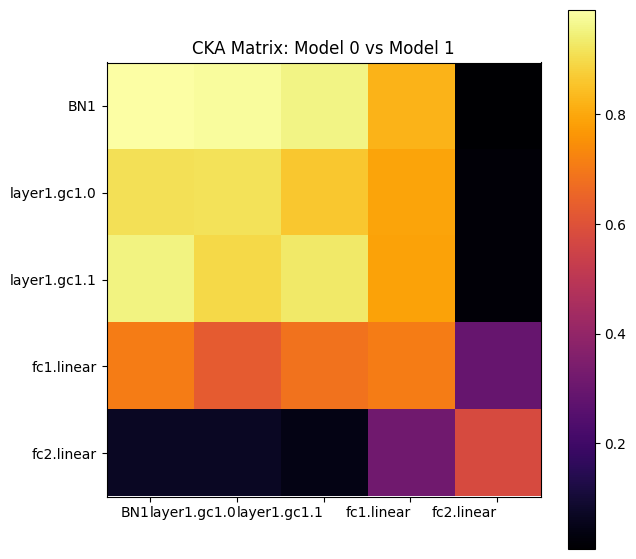

Processing CKA: 100%|█████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 335.25it/s]


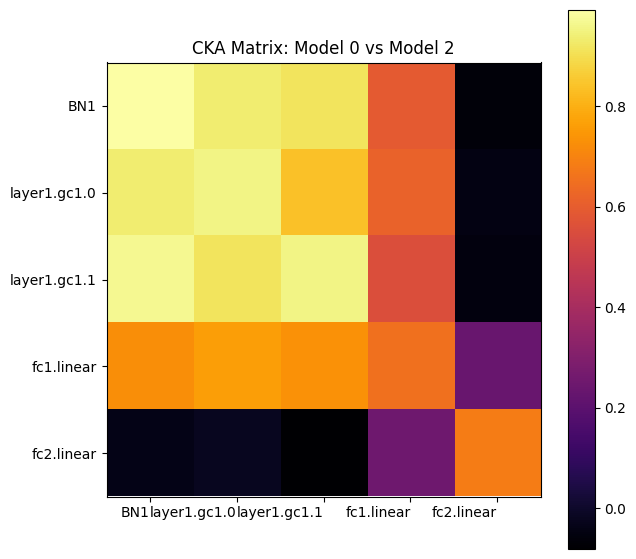

Processing CKA: 100%|█████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 329.37it/s]


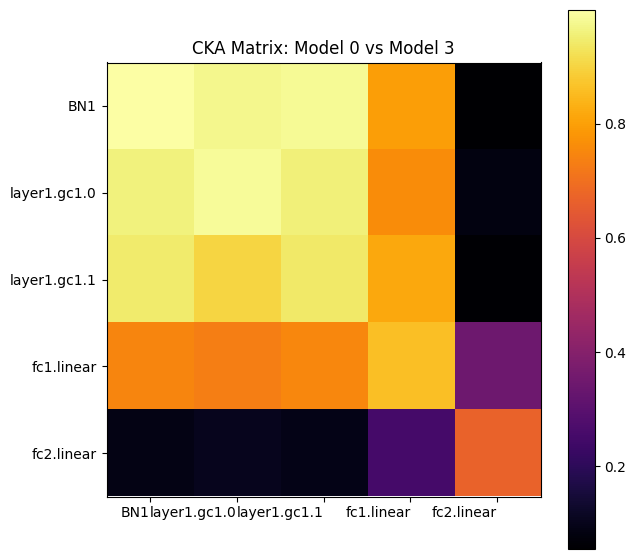

In [28]:
for i in range(modruns - 1):
    
    calculator = CKACalculator(model1=mods[0][0], model2=mods[i + 1][0], dataloader=train_loader,
                               layers_to_hook=(nn.Conv2d, nn.Linear, nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
    cka_output = calculator.calculate_cka_matrix()

    # Plot the matrix
    plt.figure(figsize=(7, 7))
    plt.imshow(cka_output.cpu().numpy(), cmap='inferno')
    plt.xticks(ticks=np.arange(len(calculator.module_names_X)), labels=calculator.module_names_X, ha="right")
    plt.yticks(ticks=np.arange(len(calculator.module_names_Y)), labels=calculator.module_names_Y)
    plt.colorbar()
    plt.title(f'CKA Matrix: Model 0 vs Model {i+1}')
    plt.show()  


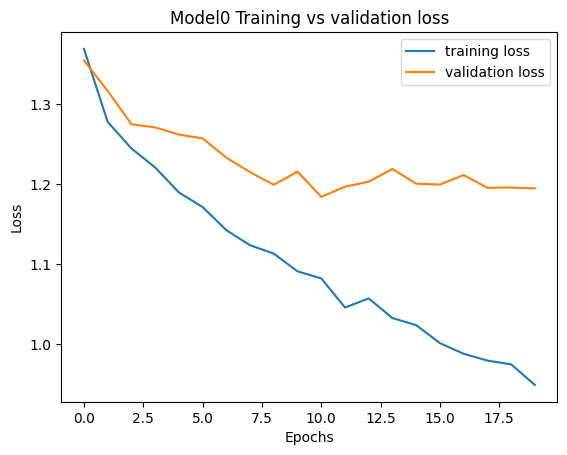

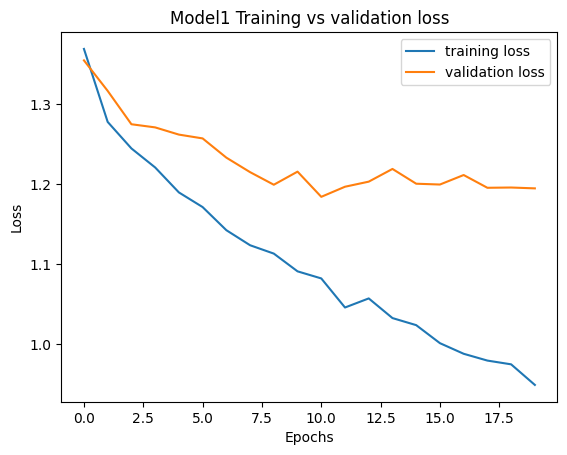

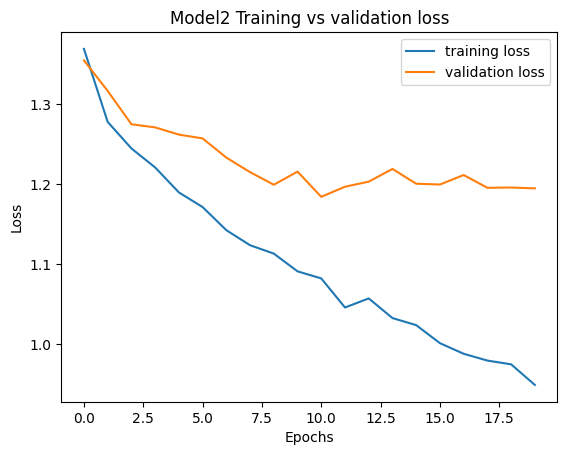

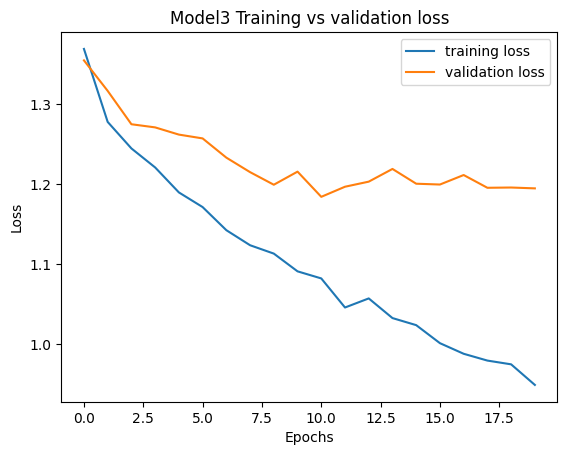

In [16]:
for i  in range (len(mods)):
    plt.plot(mods[0][1][0])
    plt.plot(mods[0][1][1])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["training loss","validation loss"])
    plt.title(f"Model{i} Training vs validation loss")
    plt.show()  